In [2]:
import os, sys
import time

import multiprocessing as mp
import itertools, functools
import re

import librosa, librosa.display

import scipy
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import torch, torch.nn as nn, torch.nn.functional as F, torch.autograd as ag


import PyQt5
import matplotlib.pyplot as plt

import IPython
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm_nb, trange

from collections import defaultdict


def next(iterator, default=None, count=1):
    ans = None
    for i in range(count):
        try:
            ans = __builtin__.next(iterator)
        except StopIteration as exc:
            if default is not None:
                return default
            else:
                raise exc
    return ans

In [3]:
torch.Tensor

torch.FloatTensor

In [2]:
def get_spectgorgamm(fname, hop_length=512, n_mels=128):
    y, sr = librosa.load(fname)
    S = librosa.feature.melspectrogram(y, sr=sr, hop_length=hop_length, n_mels=n_mels)
    log_S = librosa.amplitude_to_db(S, ref=np.max)
    return log_S, sr

def plot_spectrogramm(log_S, sr, cmap='viridis'):
    plt.figure(figsize=(20,4))
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', cmap=cmap)
    plt.title('mel power spectrogram')
    plt.colorbar(format='%+02.0f dB')
    plt.tight_layout()

In [7]:
torch.load('./saved/nn/siam-voice-to-vec.pt')

Z:\Anaconda3\lib\site-packages\torch\serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


AttributeError: Can't get attribute '_rebuild_tensor_v2' on <module 'torch._utils' from 'Z:\\Anaconda3\\lib\\site-packages\\torch\\_utils.py'>

In [3]:
def self_equal(sth):
    return sth == sth

def yield_all(sth, length):
    for i in range(length):
        yield sth[i]

def refine_spectrogramm(x):
    return np.concatenate(( x, -80 * np.ones((128, max(0, 300 - x.shape[1]))) ), axis=-1)[:, :300]

# Mining data from [LibriSpeech](http://www.openslr.org/12/) dataset

In [4]:
def compute_spectrogram_and_save(args):
    full_fname, short_fname, dir_to_save = args
    spec = list(get_spectgorgamm(full_fname))
    spec[0] = refine_spectrogramm(spec[0])
    np.save(dir_to_save + os.sep + short_fname + '.spec.npy', spec)

def mine_from_LibriSpeech_audio(LibriSpeech_dir, dir_to_save, do_it=True):
    fnames = []
    for dir_dirs_files in os.walk(LibriSpeech_dir):
        to_append = filter((lambda fname: fname.endswith('.flac')), dir_dirs_files[2])
        to_append = map((lambda fname: (dir_dirs_files[0] + os.sep + fname, fname)), to_append)
        fnames += list(to_append)
    fnames = np.array(fnames)
    
    if do_it:
        mp.Pool(os.cpu_count()).map(compute_spectrogram_and_save,
                                    zip(fnames[:, 0], fnames[:, 1], itertools.cycle((dir_to_save,))) )
    return fnames

In [18]:
dir_to_save = './some-sound/LibriSpeech-melspecs-little/'
LibriSpeech_dir = './LibriSpeech/train-other/LibriSpeech/train-other-500'

In [17]:
#mine_from_LibriSpeech_audio(LibriSpeech_dir, dir_to_save, True)

# Data

In [19]:
fnames = next(os.walk(dir_to_save))[2]

In [20]:
X = np.array([np.load(dir_to_save + os.sep + fname)[0] for fname in fnames])
Y = np.array([int(fname[: fname.find('-')]) for fname in fnames])

In [21]:
ind_tr, ind_ts = train_test_split(np.arange(len(Y)), test_size=0.1, random_state=97)

In [22]:
Y_to_X_tr = defaultdict(list)
for i in range(len(ind_tr)):
    Y_to_X_tr[Y[ind_tr[i]]].append(i)
for key in Y_to_X_tr:
    Y_to_X_tr[key] = np.array(Y_to_X_tr[key])

# Trying to train NN

In [8]:
class GlobalMaxPool1d(nn.Module):
    def forward(self, inp):
        return torch.max(inp, dim=-1)[0]

class VoiceToVec(nn.Module):
    def __init__(self, out_size):
        super(self.__class__, self).__init__()
        self.conv1 = nn.Conv1d(128, 256, 3)
        self.conv2 = nn.Conv1d(256, 512, 3)

        self.gmp1 = GlobalMaxPool1d()
        self.dropout = nn.Dropout(0.2)
        self.dense1 = nn.Linear(512, out_size)

    def forward(self, x):
        x -= torch.min(torch.min(x, 2, keepdim=True)[0], 1, keepdim=True)[0]
        x /= torch.max(torch.max(x, 2, keepdim=True)[0], 1, keepdim=True)[0]
        
        conv1_out = nn.LeakyReLU()(self.conv1(x))
        
        conv2_out = nn.LeakyReLU()(self.conv2(conv1_out))
        
        gmp1_out = self.gmp1(conv2_out)
        dense1_out = self.dense1(self.dropout(gmp1_out))
        
        return dense1_out

In [9]:
def random_triplet():
    anc_pos_ind, neg_ind = np.random.choice(list(Y_to_X_tr.keys()), size=2, replace=False)

    anchor, positive = np.random.choice(Y_to_X_tr[anc_pos_ind], size=2, replace=False)
    negative = np.random.choice(Y_to_X_tr[neg_ind])
    
    return np.array([anchor, positive, negative])

In [11]:
def random_multiplet(k):
    anc_pos_ind, *neg_inds = np.random.choice(list(Y_to_X_tr.keys()), size=1+k, replace=False)

    anchor, positive = np.random.choice(Y_to_X_tr[anc_pos_ind], size=2, replace=False)
    *negatives, = (np.random.choice(Y_to_X_tr[neg_ind]) for neg_ind in neg_inds)
    
    return [anchor, positive, negatives]

In [86]:
bla = random_triplet()

In [12]:
def iterate_minibatch(batchsize):
    for i in range(batchsize):
        yield random_triplet()

In [90]:
bla

array([  31, 1323, 2241])

In [13]:
def new_batch(batchsize):
    return X[ind_tr[np.array(list(iterate_minibatch(batchsize))).T]]

In [14]:
def sim(a, b):
    return -((a-b) ** 2).sum(dim=-1)

In [30]:
torch.set_num_threads(14)

In [31]:
model = VoiceToVec(100)

In [32]:
opt = torch.optim.Adam(model.parameters())

In [33]:
anchor, positive, negative = torch.FloatTensor(new_batch(100))
anchor_vec, positive_vec, negative_vec = map(model, (anchor, positive, negative))

loss = F.relu(1 + sim(anchor_vec, negative_vec) - sim(anchor_vec, positive_vec))

TypeError: argument 0 is not a Variable

In [27]:
cnt_epochs = 100

In [34]:
Y

array([ 116,  116,  116, ..., 8288, 8288, 8288])

In [29]:
blavec = torch.zeros(100, 128, 300)
model(blavec).sum().backward()

In [24]:
new_batch(2).shape

(3, 2, 128, 300)

In [28]:
losses = []

for ind_epoch in range(cnt_epochs):
    model.train(True)
    
    anchor, positive, negative = map(torch.FloatTensor, new_batch(100))
    
    anchor_vec, positive_vec, negative_vec = map(model, (anchor, positive, negative))
    
    loss = F.relu(1 + sim(anchor_vec, negative_vec) - sim(anchor_vec, positive_vec)).mean()
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    losses.append(loss)
    if ind_epoch % 1 == 0:
        IPython.display.clear_output(True)
        plt.plot(losses)
        plt.show()

NameError: name 'model' is not defined

In [29]:
model

NameError: name 'model' is not defined

# Testing accuracy

In [22]:
model = torch.load('./siam-voice-to-vec.pt')

In [105]:
accs = []

In [106]:
model.train(False)
for i in tqdm_nb(range(100)):
    with torch.no_grad():
        anchor, positive, negative = map(torch.FloatTensor, new_batch(100))
    
        anchor_vec, positive_vec, negative_vec = map(model, (anchor, positive, negative))
    
        acc = (sim(anchor_vec, negative_vec) <= sim(anchor_vec, positive_vec)).numpy().mean()
        accs.append(acc)
print(np.mean(accs))

HBox(children=(IntProgress(value=0), HTML(value='')))



0.9591


In [76]:
accs = []

In [115]:
0.956**20

0.4065910789576807

In [112]:
cnt_negatives = 20

model.train(False)
for i in tqdm_nb(range(1000)):
    with torch.no_grad():
        anchor, positive, negatives = random_multiplet(cnt_negatives)
        anchor, positive, negatives = X[ind_tr[anchor]], X[ind_tr[positive]], X[ind_tr[np.array(negatives)]]
        anchor_vec, positive_vec = map(model, map(torch.FloatTensor, ([anchor], [positive])))
        *negative_vecs, = model(torch.FloatTensor(negatives))
        
        anc_pos_sim = sim(anchor_vec, positive_vec)
        good = (sim(anchor_vec, x) <= anc_pos_sim for x in negative_vecs) # 
        acc = sum(good) == cnt_negatives
        
        accs.append(acc)
        
print(np.mean(accs))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


0.7848096774193548


# TODO: random_k_let

In [4]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections

# Dimension of our vector space
dimension = 500

# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 10)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp])

# Index 1000000 random vectors (set their data to a unique string)
for index in range(100000):
    v = np.random.randn(dimension)
    engine.store_vector(v, 'data_%d' % index)

# Create random query vector
query = np.random.randn(dimension)

# Get nearest neighbours
N = engine.neighbours(query)

In [6]:
from sklearn.neighbors import BallTree

In [ ]:
BallTree(

(array([  2.,   0.,   2.,   6.,   2.,   3.,   1.,   2.,   2.,  12.,  13.,
          4.,  10.,   7.,  16.,  19.,  19.,  33.,  22.,  48.,  46.,  51.,
         56.,  61.,  71.,  62.,  80.,  99., 106., 104., 146., 133., 157.,
        151., 199., 194., 212., 193., 212., 250., 240., 253., 265., 247.,
        267., 298., 285., 276., 284., 279., 289., 311., 254., 248., 228.,
        231., 227., 215., 220., 228., 222., 184., 184., 156., 139., 141.,
        135., 126., 101.,  91.,  61.,  70.,  55.,  54.,  49.,  39.,  27.,
         50.,  36.,  17.,  25.,  14.,  11.,   8.,  10.,   6.,  10.,   4.,
          4.,   3.,   4.,   1.,   4.,   3.,   0.,   2.,   0.,   0.,   1.,
          2.]),
 array([-3.4550227 , -3.38357395, -3.3121252 , -3.24067645, -3.16922769,
        -3.09777894, -3.02633019, -2.95488144, -2.88343269, -2.81198393,
        -2.74053518, -2.66908643, -2.59763768, -2.52618893, -2.45474017,
        -2.38329142, -2.31184267, -2.24039392, -2.16894517, -2.09749641,
        -2.02604766, -1.95

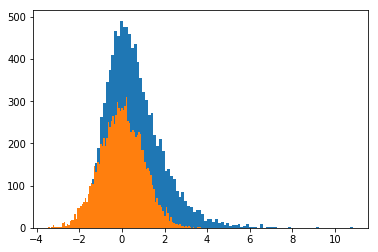

In [24]:
plt.hist(np.random.gumbel(size=10000), bins=100);
plt.hist(np.random.normal(size=10000), bins=100)

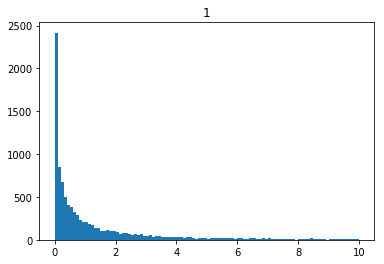

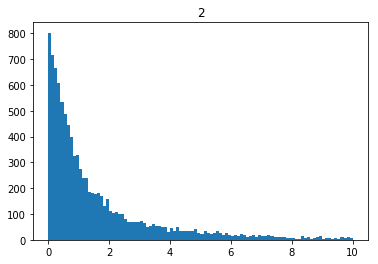

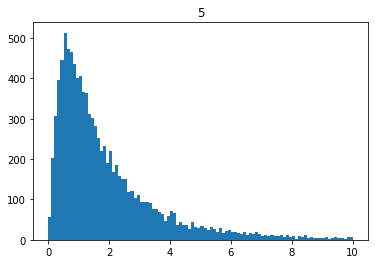

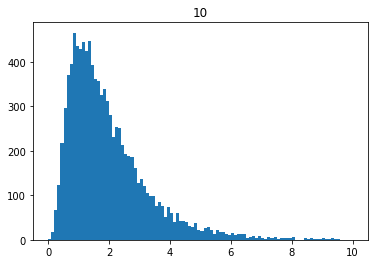

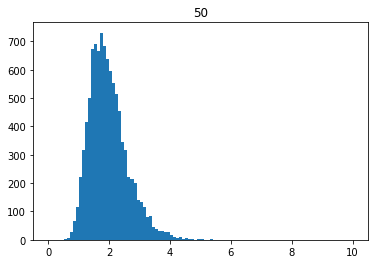

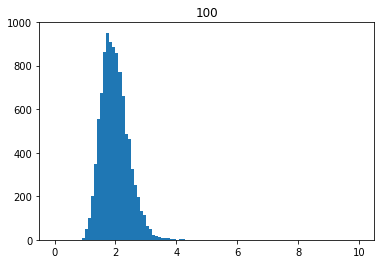

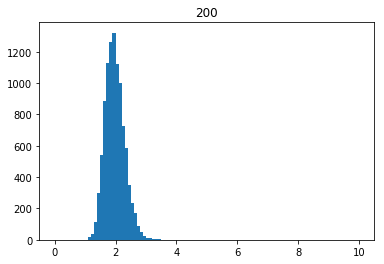

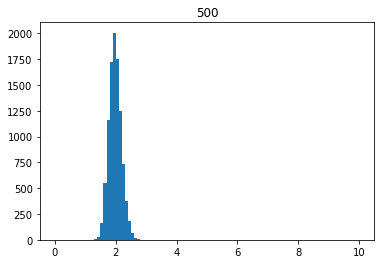

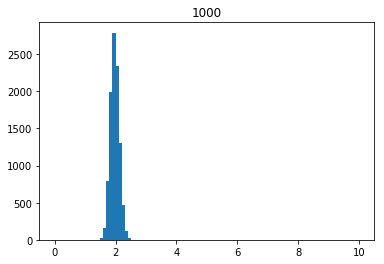

In [21]:
for dim in [1, 2, 5, 10, 50, 100, 200, 500, 1000]:
    z = np.random.gumbel(size=[10000, dim])
    z_radius = (z ** 2).mean(-1)
    plt.title(dim)
    plt.hist(z_radius, range=[0, 10], bins=100)
    plt.show()

(array([6.496e+03, 2.232e+03, 8.000e+02, 3.060e+02, 9.700e+01, 4.600e+01,
        1.300e+01, 5.000e+00, 3.000e+00, 2.000e+00]),
 array([3.92213354e-05, 2.04752004e+00, 4.09500086e+00, 6.14248169e+00,
        8.18996251e+00, 1.02374433e+01, 1.22849242e+01, 1.43324050e+01,
        1.63798858e+01, 1.84273666e+01, 2.04748474e+01]),
 <a list of 10 Patch objects>)

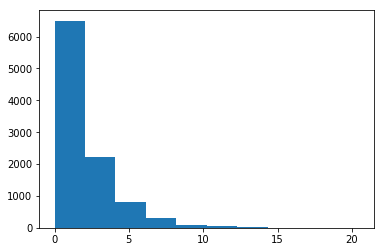